ПРОГНОЗИРОВАНИЕ КОЛИЧЕСТВА БРОНИРОВАНИЙ БЕЗ ОТМЕНЫ ДЛЯ КОМПАНИИ  RAKUTEN НА ЯНВАРЬ-ФЕВРАЛЬ 2019 
(с использованием алгоритма XGBoost)

# Подготовка к выполнению

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Разведовательный анализ и чистка данных (этап 1)

2.1. Загружаем в датафрейм данные компании Rakuten и делаем первый анализ

In [2]:
df_rakuten=pd.read_csv('rakuten_shinchitose.csv',encoding="shift_jisx0213")

In [3]:
df_rakuten.head()

,予約ステータス,楽天予約番号,御社予約番号,楽パック予約番号,予約受付日時,予約確認日時,キャンセル受付日時,キャンセル日時,乗車人数,内子供人数,...,非課税金額,キャンセル料,備考,付帯サービス,料金変更理由,キャリア,機種,キャンセル区分,回答,決済方法
0,キャンセル済（予約直後）,RC32457434637117616,NaN,NaN,2016/2/16 17:41,NaN,2016/2/16 17:47,NaN,3,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,オンラインカード決済
1,予約確認済,RC32457434645237633,NaN,NaN,2016/2/16 17:55,2016/2/16 18:18,NaN,NaN,3,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済
2,予約確認済,RC62457437572294437,NaN,NaN,2016/2/19 15:53,2016/2/19 16:01,NaN,NaN,1,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1",NaN,NaN,NaN,NaN,NaN,現地決済
3,予約確認済,RC72457438509836329,NaN,NaN,2016/2/20 14:09,2016/2/20 15:43,NaN,NaN,1,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 禁煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済
4,予約確認済,RC72457438821737647,NaN,NaN,2016/2/20 22:49,2016/2/21 8:58,NaN,NaN,2,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 禁煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済


In [4]:
df_rakuten.shape

(3983, 48)

In [5]:
df_rakuten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   予約ステータス         3983 non-null   object 
 1   楽天予約番号          3983 non-null   object 
 2   御社予約番号          0 non-null      float64
 3   楽パック予約番号        2 non-null      object 
 4   予約受付日時          3983 non-null   object 
 5   予約確認日時          3711 non-null   object 
 6   キャンセル受付日時       756 non-null    object 
 7   キャンセル日時         513 non-null    object 
 8   乗車人数            3983 non-null   int64  
 9   内子供人数           3983 non-null   int64  
 10  予約フライト№         3981 non-null   object 
 11  宿泊施設名           83 non-null     object 
 12  宿泊施設住所          83 non-null     object 
 13  宿泊施設電話番号        83 non-null     object 
 14  予約番号（宿泊）        83 non-null     object 
 15  貸渡方法            3983 non-null   object 
 16  貸渡日時            3983 non-null   object 
 17  貸渡営業所コード        3983 non-null   i

- Датасет содержит 3983 наблюдения и 48 признаков
- Есть пустые данные
- Необходимо воспользоваться теблицей description для преобразования японских меток
- Данные разных типов, в т.ч. объекты, нужно выяснить, какие из них нам будут нужны для прогноза

2.2. Делаем перевод по таблице description 

In [6]:
df_desc=pd.read_csv('columns_description.csv',encoding="shift_jisx0213")

In [7]:
df_desc.head()

,Unnamed: 0,Table,Row(JP),Row(EN),Description
0,1,rakuten_{shop}.csv,予約ステータス,booking_status,"status of booking (""noshow""=no show up, ""キャンセル..."
1,2,rakuten_{shop}.csv,楽天予約番号,rakuten_booking_number,booking number created by OTA
2,5,rakuten_{shop}.csv,御社予約番号,company_booking_number,booking number created by company
3,6,rakuten_{shop}.csv,楽パック予約番号,rakupack_booking_number,unknown
4,7,rakuten_{shop}.csv,予約受付日時,request_date_time,date and time of the request made


Составляем словарь:

In [8]:
en=df_desc.loc[:,"Row(EN)"]
jap=df_desc.loc[:,"Row(JP)"]

In [9]:
new_names={}
for i in range(51):
    new_names[jap[i]]=en[i]
print(new_names)

{'予約ステータス': 'booking_status', '楽天予約番号': 'rakuten_booking_number', '御社予約番号': 'company_booking_number', '楽パック予約番号': 'rakupack_booking_number', '予約受付日時': 'request_date_time', '予約確認日時': 'request_confirmed_date_time', 'キャンセル受付日時': 'cancel_request_date_time', 'キャンセル日時': 'cancel_confirmed_date_time', '乗車人数': 'number_of_passengers', '内子供人数': 'number_of_children', '予約フライト№': 'flight_number', '宿泊施設名': 'accommodation_name', '宿泊施設住所': 'accommodation_address', '宿泊施設電話番号': 'accommodation_phone_number', '予約番号（宿泊）': 'accommodation_booking_number', '貸渡方法': 'pickup_method', '貸渡日時': 'pickup_date_time', '貸渡営業所コード': 'pickup_shop_code', '貸渡営業所名': 'pickup_shop_name', '返却日時': 'return_date_time', '返却営業所コード': 'return_shop_code', '返却営業所名': 'return_shop_name', '事業者車両クラスコード': 'company_car_class_code', '詳細車両クラスコード': 'detail_car_class_code', '詳細車両クラス名': 'detail_car_class_name', 'AT/MT区分': 'transmission', 'キャンペーン': 'campaign', '車両属性': 'car_attribute', '基本料金': 'basic_price', '乗捨料金': 'drop_off_fee', '付帯サービス料金合計': 'opti

Заменяем метки столбцов:

In [10]:
df_rakuten.rename(columns=new_names, inplace=True)

In [11]:
df_rakuten.head()

,booking_status,rakuten_booking_number,company_booking_number,rakupack_booking_number,request_date_time,request_confirmed_date_time,cancel_request_date_time,cancel_confirmed_date_time,number_of_passengers,number_of_children,...,non_taxable_amount,cancel_fee,memo,options,cancellation_reason,mobile_career,mobile_model,cancellation_classification,answer,payment_method
0,キャンセル済（予約直後）,RC32457434637117616,NaN,NaN,2016/2/16 17:41,NaN,2016/2/16 17:47,NaN,3,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,オンラインカード決済
1,予約確認済,RC32457434645237633,NaN,NaN,2016/2/16 17:55,2016/2/16 18:18,NaN,NaN,3,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済
2,予約確認済,RC62457437572294437,NaN,NaN,2016/2/19 15:53,2016/2/19 16:01,NaN,NaN,1,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1",NaN,NaN,NaN,NaN,NaN,現地決済
3,予約確認済,RC72457438509836329,NaN,NaN,2016/2/20 14:09,2016/2/20 15:43,NaN,NaN,1,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 禁煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済
4,予約確認済,RC72457438821737647,NaN,NaN,2016/2/20 22:49,2016/2/21 8:58,NaN,NaN,2,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 禁煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,現地決済


In [12]:
df_rakuten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   booking_status                3983 non-null   object 
 1   rakuten_booking_number        3983 non-null   object 
 2   company_booking_number        0 non-null      float64
 3   rakupack_booking_number       2 non-null      object 
 4   request_date_time             3983 non-null   object 
 5   request_confirmed_date_time   3711 non-null   object 
 6   cancel_request_date_time      756 non-null    object 
 7   cancel_confirmed_date_time    513 non-null    object 
 8   number_of_passengers          3983 non-null   int64  
 9   number_of_children            3983 non-null   int64  
 10  flight_number                 3981 non-null   object 
 11  accommodation_name            83 non-null     object 
 12  accommodation_address         83 non-null     object 
 13  acc

# Разведовательный анализ и чистка данных (этап 2)¶

3.1. Поскольку нам нужно прогнозировать число бронирований без отмены, то полезными данными из этой таблицы будут: 
     - booking_status (сможем отобрать только без отмены), 
     - rakuten_booking_number (это уникальные id, по которым и будем определять искомое количество заказов)
     - request_date_time (даты временного ряда)
     
     Остальные данные не являются признаками, влияющими на целевую переменную, кроме flight_number (можно было бы проанализировать корреляцию с рейсами, затем для прогноза посмотреть расписание и и также использовать в модели как feature; но в виду отсутствия времени я не рассматривала этот признак)

In [13]:
df5 = df_rakuten.loc[:, ['booking_status','rakuten_booking_number','request_date_time']]

In [14]:
df5.head()

,booking_status,rakuten_booking_number,request_date_time
0,キャンセル済（予約直後）,RC32457434637117616,2016/2/16 17:41
1,予約確認済,RC32457434645237633,2016/2/16 17:55
2,予約確認済,RC62457437572294437,2016/2/19 15:53
3,予約確認済,RC72457438509836329,2016/2/20 14:09
4,予約確認済,RC72457438821737647,2016/2/20 22:49


3.2. Удалим строки с отменой бронирования (для фильтра используем расшифровку из description)   

In [15]:
df3 = df5.query("booking_status in ['予約確認済','予約確認済（料金変更あり)']")

In [16]:
df3.shape

(3203, 3)

3.2. Сгруппируем количество заказов по дням: 

In [17]:
df3['request_date_time'] = pd.to_datetime(df_rakuten['request_date_time']).dt.date

C:\Users\viktoriya_rakhuba\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df4=df3.groupby("request_date_time")["rakuten_booking_number"].nunique().to_frame()
df4.reset_index(inplace=True)
df4.rename(columns={'rakuten_booking_number':'amount_of_bookings'}, inplace=True)
df4

,request_date_time,amount_of_bookings
0,2016-02-16,1
1,2016-02-19,1
2,2016-02-20,2
3,2016-02-22,3
4,2016-02-23,1
...,...,...
926,2018-12-27,2
927,2018-12-28,2
928,2018-12-29,1
929,2018-12-30,3


3.3. Оценим статистические характеристики:

In [19]:
df4.describe()

,amount_of_bookings
count,931.000000
mean,3.440387
std,2.556762
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,20.000000


В среднем 3-4 заказа в день. 75% квантиль=5, а максимум 20, т.е. датасет содержит выбросы. 
Узнаем дату с максимальным числом заказов и попробуем проследить, является ли это случайностью или вызвано какими-то событиями. Для этого воспользуемся таблицей events.

In [20]:
df4.loc[df4['amount_of_bookings'] == 20]

,request_date_time,amount_of_bookings
779,2018-07-24,20


In [21]:
df_events=pd.read_csv('events_Hokkaido.csv',encoding="shift_jisx0213")

In [22]:
df_events20=df_events.loc[df_events['start_date']=='2018/7/24']
df_events20

,city_id,title,address,start_date,end_date,lng,lat
10131,1504,美輪明宏 ロマンティック音楽会 ‾郷愁 ノスタルジア‾,北海道札幌市中央区北1条西1丁目,2018/7/24,2018/7/24,141.356003,43.062302
10132,1504,土岐麻子,北海道札幌市中央区北二条東3-2-5,2018/7/24,2018/7/24,141.360001,43.065201
10133,1514,氣志團,北海道函館市美原1-19-12,2018/7/24,2018/8/1,140.753006,41.814201


На искомую дату приходится 3 события. Посмотрим на остальные данные таблицы:

In [23]:
df_events_by_date=df_events.groupby("start_date")["title"].nunique().to_frame()
df_events_by_date.reset_index(inplace=True)
df_events_by_date.describe()

,title
count,1230.000000
mean,10.220325
std,10.044218
min,1.000000
25%,3.000000
50%,7.000000
75%,14.000000
max,98.000000


Максимальное число событий=98, среднее=10, таким образом 3 никак не объясняет количество заказов 20.

3.4. Продолжим анализ таблицы с заказами:

In [24]:
df4.amount_of_bookings.unique()

array([ 1,  2,  3,  5,  4,  6,  8,  7, 10,  9, 12, 11, 14, 13, 15, 19, 20],
      dtype=int64)

In [25]:
df4.amount_of_bookings.value_counts()

1     234
2     196
3     142
4     111
5      74
6      69
7      35
8      29
9      16
10      9
11      5
12      4
13      2
15      2
19      1
14      1
20      1
Name: amount_of_bookings, dtype: int64

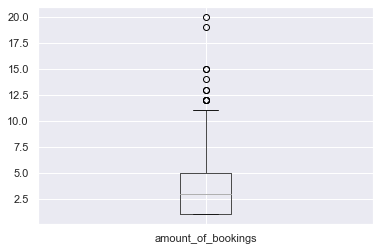

In [26]:
df4.boxplot(column =['amount_of_bookings'], grid = True)

In [27]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   request_date_time   931 non-null    object
 1   amount_of_bookings  931 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.7+ KB


3.5. Избавимся от выбросов, используя самое простое правило прибавления к верхнему квартилю межквартильного интервала и заменим выбросы на значение верхней границы =11

In [28]:
df4.amount_of_bookings.loc[df4.amount_of_bookings > 11 ] = 11

C:\Users\viktoriya_rakhuba\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
df4.describe()

,amount_of_bookings
count,931.000000
mean,3.401719
std,2.395281
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,11.000000


3.6. Оценим стационарность ряда, тренд, сезонность:

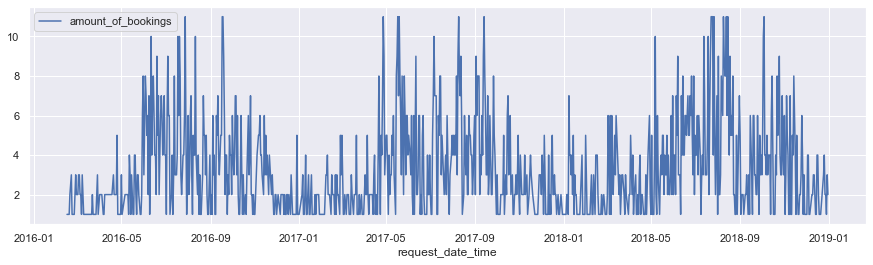

In [30]:
df4.plot(figsize=(15,4),x='request_date_time',y='amount_of_bookings')

Ряд имеет ярко выраженную сезонность: в летние месяцы число бронирований выше. 

3.7.Подготовим набор признаков для модели. В качестве признаков будем использовать данные о погоде, выходных и событиях. 

In [31]:
df_whether=pd.read_csv('weather_Hokkaido.csv')

In [32]:
df_whether.head()

,date,city_id,city,district,conditions,high_temp,low_temp,rain_probability
0,2017/7/9,1504,中央区,札幌市,曇時々雨,30,21,60
1,2017/7/9,1505,北区,札幌市,曇時々雨,30,21,60
2,2017/7/9,1506,東区,札幌市,曇時々雨,30,21,60
3,2017/7/9,1507,白石区,札幌市,曇時々雨,29,21,60
4,2017/7/9,1508,豊平区,札幌市,曇時々雨,29,21,60


Таблица содержит данные по нескольким городам в рассматриваемом регионе. А нам необходимо привязать данные к имеющемуся временному ряду с бронированиями, которые были также по разным городам этого региона.
По хорошему надо бы проанализировать в каких городах чаще всего деляются заказы (и по ним брать погоду), либо же по таблице погоды выявить наиболее характерную в целом по региону по сезонам. 
Но условиях недостатка времени я взяла просто первое значение в группе по дате:

In [33]:
df_whether=pd.read_csv('weather_Hokkaido.csv')
df_whether_short=df_whether.groupby('date').first().reset_index()
df_whether_short

,date,city_id,city,district,conditions,high_temp,low_temp,rain_probability
0,2017/10/1,1504,中央区,札幌市,曇時々雨,20,16,50
1,2017/10/10,1504,中央区,札幌市,曇後雨,12,8,50
2,2017/10/11,1504,中央区,札幌市,雨後曇,15,8,50
3,2017/10/12,1504,中央区,札幌市,曇後晴,13,8,20
4,2017/10/13,1504,中央区,札幌市,曇後雨,14,6,60
...,...,...,...,...,...,...,...,...
557,2019/2/5,1504,中央区,札幌市,曇時々雪,-3,-7,60
558,2019/2/6,1504,中央区,札幌市,曇時々雪,-4,-9,60
559,2019/2/7,1504,中央区,札幌市,曇り,-8,-13,40
560,2019/2/8,1504,中央区,札幌市,曇り,-5,-13,40


Оставим теперь только данные о погоде по временному ряду дат:

In [34]:
df_whether_short.drop(['city_id','city','district'], axis=1, inplace=True) 

In [35]:
df_whether_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              562 non-null    object
 1   conditions        562 non-null    object
 2   high_temp         562 non-null    int64 
 3   low_temp          562 non-null    int64 
 4   rain_probability  562 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 22.1+ KB


В таблице 562 строки без пустых данных

Для мерджа с исходным датафремом приведём в соответствие имена и типы данных столбцов:

In [36]:
df4.rename(columns={'request_date_time':'date'}, inplace=True)
df4.head()

,date,amount_of_bookings
0,2016-02-16,1
1,2016-02-19,1
2,2016-02-20,2
3,2016-02-22,3
4,2016-02-23,1


In [37]:
df_whether_short['date'] = pd.to_datetime(df_whether_short['date']).dt.date

In [38]:
df_whether_short.head()

,date,conditions,high_temp,low_temp,rain_probability
0,2017-10-01,曇時々雨,20,16,50
1,2017-10-10,曇後雨,12,8,50
2,2017-10-11,雨後曇,15,8,50
3,2017-10-12,曇後晴,13,8,20
4,2017-10-13,曇後雨,14,6,60


Выполняем слияние таблиц с целью формирования матрицы для модели

In [39]:
df_merge_1 = pd.merge(df4, df_whether_short, on='date',how='left')

In [40]:
df_merge_1.head()

,date,amount_of_bookings,conditions,high_temp,low_temp,rain_probability
0,2016-02-16,1,NaN,NaN,NaN,NaN
1,2016-02-19,1,NaN,NaN,NaN,NaN
2,2016-02-20,2,NaN,NaN,NaN,NaN
3,2016-02-22,3,NaN,NaN,NaN,NaN
4,2016-02-23,1,NaN,NaN,NaN,NaN


In [41]:
df_merge_1.shape

(931, 6)

In [42]:
df_merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                931 non-null    object 
 1   amount_of_bookings  931 non-null    int64  
 2   conditions          468 non-null    object 
 3   high_temp           468 non-null    float64
 4   low_temp            468 non-null    float64
 5   rain_probability    468 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 50.9+ KB


Часть временных меток оказались с незаполненными данными о погоде. В качестве значений conditions возьмём наиболее часто повторяющееся значение в столбце, а для числовых данных - их медианы: 

In [43]:
freq_cond=pd.value_counts(df_whether_short['conditions'].values, sort=True).head(1)
high_temp_median=df_whether_short.loc[:,"high_temp"].median()
low_temp_median=df_whether_short.loc[:,"low_temp"].median()
rain_median=df_whether_short.loc[:,"rain_probability"].median()

In [44]:
keys=freq_cond.keys()
whether=keys[0]

In [45]:
df_merge_1['conditions'].fillna(whether,inplace=True)
df_merge_1['high_temp'].fillna(high_temp_median,inplace=True)
df_merge_1['low_temp'].fillna(low_temp_median,inplace=True)
df_merge_1['rain_probability'].fillna(rain_median,inplace=True)
df_merge_1.head()

,date,amount_of_bookings,conditions,high_temp,low_temp,rain_probability
0,2016-02-16,1,晴時々曇,14.0,7.0,30.0
1,2016-02-19,1,晴時々曇,14.0,7.0,30.0
2,2016-02-20,2,晴時々曇,14.0,7.0,30.0
3,2016-02-22,3,晴時々曇,14.0,7.0,30.0
4,2016-02-23,1,晴時々曇,14.0,7.0,30.0


In [46]:
df_merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                931 non-null    object 
 1   amount_of_bookings  931 non-null    int64  
 2   conditions          931 non-null    object 
 3   high_temp           931 non-null    float64
 4   low_temp            931 non-null    float64
 5   rain_probability    931 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 50.9+ KB


Пустых данных нет

Дополним матрицу данными о выходных:

In [47]:
df_holidays=pd.read_csv('holidays_Japan.csv')

In [48]:
df_holidays.head()

,day,Japan
0,2015/1/1,1
1,2015/1/2,0
2,2015/1/3,0
3,2015/1/4,0
4,2015/1/5,0


Приводим таблицу к виду, удобному для мерджа:

In [49]:
df_holidays.rename(columns={'day':'date'}, inplace=True)
df_holidays.rename(columns={'Japan':'holidays'}, inplace=True)
df_holidays['date'] = pd.to_datetime(df_holidays['date']).dt.date

In [50]:
df_merge_2 = pd.merge(df_merge_1, df_holidays, on='date',how='left')

In [51]:
df_merge_2.head()

,date,amount_of_bookings,conditions,high_temp,low_temp,rain_probability,holidays
0,2016-02-16,1,晴時々曇,14.0,7.0,30.0,0
1,2016-02-19,1,晴時々曇,14.0,7.0,30.0,0
2,2016-02-20,2,晴時々曇,14.0,7.0,30.0,0
3,2016-02-22,3,晴時々曇,14.0,7.0,30.0,0
4,2016-02-23,1,晴時々曇,14.0,7.0,30.0,0


Аналогично подготавливаем таблицу df_events_by_date (которая уже содержит количество ивентов по датам)

In [52]:
df_events_by_date.rename(columns={'start_date':'date'}, inplace=True)
df_events_by_date.rename(columns={'title':'amount_of_events'}, inplace=True)
df_events_by_date['date'] = pd.to_datetime(df_events_by_date['date']).dt.date

In [53]:
df_merge_3 = pd.merge(df_merge_2, df_events_by_date, on='date',how='left')

In [54]:
df_merge_3

,date,amount_of_bookings,conditions,high_temp,low_temp,rain_probability,holidays,amount_of_events
0,2016-02-16,1,晴時々曇,14.0,7.0,30.0,0,1.0
1,2016-02-19,1,晴時々曇,14.0,7.0,30.0,0,NaN
2,2016-02-20,2,晴時々曇,14.0,7.0,30.0,0,10.0
3,2016-02-22,3,晴時々曇,14.0,7.0,30.0,0,NaN
4,2016-02-23,1,晴時々曇,14.0,7.0,30.0,0,NaN
...,...,...,...,...,...,...,...,...
926,2018-12-27,2,曇時々雪,-3.0,-7.0,60.0,0,11.0
927,2018-12-28,2,曇時々雪,-2.0,-5.0,60.0,0,6.0
928,2018-12-29,1,雪,1.0,-5.0,90.0,0,6.0
929,2018-12-30,3,曇時々雪,1.0,-3.0,50.0,0,3.0


In [55]:
df_merge_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 930
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                931 non-null    object 
 1   amount_of_bookings  931 non-null    int64  
 2   conditions          931 non-null    object 
 3   high_temp           931 non-null    float64
 4   low_temp            931 non-null    float64
 5   rain_probability    931 non-null    float64
 6   holidays            931 non-null    int64  
 7   amount_of_events    890 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 65.5+ KB


Нужно заполнить пустые данные в amount_of_events 

In [56]:
events_median=df_events_by_date.loc[:,"amount_of_events"].median()
df_merge_3['amount_of_events'].fillna(events_median,inplace=True)

In [57]:
df_merge_3.shape

(931, 8)

Матрица для обучения модели почти готова, осталось кодировать категориальные данные в столбце conditions. Воспользуемся одним из простых способов кодирования:  

In [58]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(df_merge_3.conditions)
cond_enc=enc.transform(df_merge_3.conditions)
df_merge_3['conditions'] = cond_enc


In [59]:
df_merge_3.head()

,date,amount_of_bookings,conditions,high_temp,low_temp,rain_probability,holidays,amount_of_events
0,2016-02-16,1,4,14.0,7.0,30.0,0,1.0
1,2016-02-19,1,4,14.0,7.0,30.0,0,7.0
2,2016-02-20,2,4,14.0,7.0,30.0,0,10.0
3,2016-02-22,3,4,14.0,7.0,30.0,0,7.0
4,2016-02-23,1,4,14.0,7.0,30.0,0,7.0


# Моделирование

Целевой переменной модели является количество бронирований в день (amount_of_bookings), а признаками - conditions,	high_temp,	low_temp,	rain_probability,	holidays,	amount_of_events.

Поскольку данные имеют примерно один порядок (единицы и десятки) в целях экономии времени попробуем в первом приближении не нормализовать их, а использовать в исходном виде.

По условию задачи используем библиотеку xgboost, с помощью которой будем использовать данный алгоритм для синтеза регрессионной модели.

In [60]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

4.1. Поскольку мы прогнозируем врменной ряд, вводим предыисторию (лаги)

In [61]:
df_xgboost = df_merge_3.copy()

predict_period=30
for i in range(predict_period, predict_period + 30):
    df_xgboost[f'lag_{i}'] = df_xgboost.amount_of_bookings.shift(i)

Удаляем пустые данные, возникшие из-за невозможности включить в расчёт временные метки до начала ряда

In [62]:
df_xgboost.dropna(inplace=True)

4.2. Делаем даты индексами ряда:

In [63]:
df_xgboost.set_index('date', inplace=True)

4.3. Выделяем столбец искомой переменной и матрицу признаков, а также отделяем обучающую и тестовую выборки.

In [64]:
train = df_xgboost[:-predict_period]
test = df_xgboost[-predict_period:]
y_train = train.amount_of_bookings
X_train = train.drop('amount_of_bookings', 1)
y_test = test.amount_of_bookings
X_test = test.drop('amount_of_bookings', 1)

4.4. Загружаем и подгоняем модель:

In [65]:
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=777)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=777, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

4.5. Делаем прогноз на тестовой выборке:

In [66]:
forecast = xgb.predict(X_test)

Округляем до целых чисел, т.к. число заказов не может быть дробным.

In [67]:
for i in range(len(forecast)):
    forecast[i]=round(forecast[i])
forecast

array([3., 2., 2., 2., 3., 3., 4., 5., 4., 4., 4., 3., 5., 2., 2., 1., 2.,
       6., 2., 6., 2., 3., 3., 4., 2., 2., 3., 2., 3., 4.], dtype=float32)

4.6. Оценим точность модели с помощью средней абсолютной ошибки:

In [68]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test, forecast)
mae

1.3333333333333333

Модель ошибается более чем на одно бронирование в день. 

4.7. Прогнозирование количества заказов на январь-февраль 2019г.

В условиях дефицита времени не успеваю подобрать оптимальные параметры для модели, поэтому буду использовать для прогноза полученные при первом фиттинге.

Модели нужно подать матрицу признаков. Сформируем её на январь-февраль 2019 года, извлекая данные из таблиц whether, holidays,events. 
Временнную предыисторию возьмём для аналогичного периода 2018 года (т.к. зимой количество заказов меньше, чем летом). Выполним преобразования над таблицами, чтобы получить искомый датафрейм. В таблице погоды не для всех дат есть данные, поэтому на желаемый период у нас будет 48 прогнозов. 

In [69]:
for_pred = df_xgboost[:-286]

In [70]:
for_pred_1= for_pred[-50:]

In [71]:
for_pred_1.drop(['amount_of_bookings','conditions','high_temp','low_temp','rain_probability','holidays','amount_of_events'], axis=1, inplace=True)

C:\Users\viktoriya_rakhuba\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [72]:
df_whether1= df_whether[-12000:]

In [73]:
df_whether_short=df_whether1.groupby('date').first().reset_index()

In [74]:
df_whether_short.drop(['city_id','city','district'], axis=1, inplace=True)

In [75]:
df_whether_short['date'] = pd.to_datetime(df_whether_short['date']).dt.date

In [76]:
df_merge_pred = pd.merge(df_whether_short, df_holidays, on='date',how='left')

In [77]:
enc = LabelEncoder()
enc.fit(df_merge_pred.conditions)
cond_enc=enc.transform(df_merge_pred.conditions)
df_merge_pred['conditions'] = cond_enc
df_merge_pred

,date,conditions,high_temp,low_temp,rain_probability,holidays
0,2019-01-01,7,-3,-9,60,1
1,2019-01-10,6,-1,-6,70,0
2,2019-01-12,5,-3,-8,10,1
3,2019-01-13,3,-2,-11,20,1
4,2019-01-15,6,1,-5,50,0
5,2019-01-16,6,-3,-11,70,0
6,2019-01-17,6,-3,-10,50,0
7,2019-01-18,4,0,-4,10,0
8,2019-01-19,6,0,-6,70,0
9,2019-01-02,3,0,-7,20,0


In [78]:
df_merge_pred_1 = pd.merge(df_merge_pred, df_events_by_date, on='date',how='left')

In [79]:
events_median=df_events_by_date.loc[:,"amount_of_events"].median()
df_merge_pred_1['amount_of_events'].fillna(events_median,inplace=True)

In [80]:
df_sorted = df_merge_pred_1.sort_values(by='date',ascending=True)

In [81]:
df_sorted = df_sorted.reset_index(drop=True)
for_pred_1 = for_pred_1.reset_index(drop=True)

In [82]:
df_for_forecast=df_sorted.join(for_pred_1)
df_for_forecast

,date,conditions,high_temp,low_temp,rain_probability,holidays,amount_of_events,lag_30,lag_31,lag_32,...,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59
0,2019-01-01,7,-3,-9,60,1,7.0,1.0,1.0,1.0,...,3.0,2.0,3.0,2.0,2.0,1.0,1.0,3.0,2.0,6.0
1,2019-01-02,3,0,-7,20,0,1.0,3.0,1.0,1.0,...,5.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,3.0,2.0
2,2019-01-03,3,1,-6,30,0,3.0,3.0,3.0,1.0,...,2.0,5.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,3.0
3,2019-01-04,6,0,-3,70,0,1.0,3.0,3.0,3.0,...,1.0,2.0,5.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0
4,2019-01-05,6,-1,-4,50,0,7.0,2.0,3.0,3.0,...,4.0,1.0,2.0,5.0,3.0,2.0,3.0,2.0,2.0,1.0
5,2019-01-06,6,-2,-7,60,0,9.0,4.0,2.0,3.0,...,3.0,4.0,1.0,2.0,5.0,3.0,2.0,3.0,2.0,2.0
6,2019-01-07,3,-1,-8,40,0,7.0,3.0,4.0,2.0,...,2.0,3.0,4.0,1.0,2.0,5.0,3.0,2.0,3.0,2.0
7,2019-01-08,6,-1,-6,50,0,7.0,1.0,3.0,4.0,...,2.0,2.0,3.0,4.0,1.0,2.0,5.0,3.0,2.0,3.0
8,2019-01-09,1,3,-4,50,0,2.0,5.0,1.0,3.0,...,2.0,2.0,2.0,3.0,4.0,1.0,2.0,5.0,3.0,2.0
9,2019-01-10,6,-1,-6,70,0,4.0,3.0,5.0,1.0,...,2.0,2.0,2.0,2.0,3.0,4.0,1.0,2.0,5.0,3.0


In [83]:
df_for_forecast.set_index('date', inplace=True)

Выполняем прогноз по матрице признаков:

In [84]:
forecast_2019 = xgb.predict(df_for_forecast)

Округляем число заказов:

In [85]:
for i in range(len(forecast_2019)):
    forecast_2019[i]=round(forecast_2019[i])
forecast_2019

array([1., 1., 1., 3., 2., 1., 4., 3., 4., 3., 3., 2., 3., 0., 2., 2., 3.,
       2., 1., 1., 3., 2., 3., 2., 2., 1., 1., 3., 2., 1., 1., 0., 1., 2.,
       1., 1., 3., 3., 1., 2., 4., 3., 1., 1., 3., 3., 2., 1.],
      dtype=float32)

Формируем таблицу с прогнозом:

In [86]:
dates = pd.date_range('2019-01-01', '2019-02-17', freq='D')
dates

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17'],
              dtype='datetime64[ns]', freq='D')

In [87]:
predictions=pd.DataFrame({'date':dates,'amount_of_bookings':forecast_2019})
predictions

,date,amount_of_bookings
0,2019-01-01,1.0
1,2019-01-02,1.0
2,2019-01-03,1.0
3,2019-01-04,3.0
4,2019-01-05,2.0
5,2019-01-06,1.0
6,2019-01-07,4.0
7,2019-01-08,3.0
8,2019-01-09,4.0
9,2019-01-10,3.0


In [88]:
predictions=pd.DataFrame({'date':dates,'amount_of_bookings':forecast_2019})


In [89]:
predictions = predictions.astype({"amount_of_bookings": int})
predictions

,date,amount_of_bookings
0,2019-01-01,1
1,2019-01-02,1
2,2019-01-03,1
3,2019-01-04,3
4,2019-01-05,2
5,2019-01-06,1
6,2019-01-07,4
7,2019-01-08,3
8,2019-01-09,4
9,2019-01-10,3


Сохраняем прогноз в csv файл:

In [90]:
predictions.to_csv  (r'forecast_2019_rakuten.csv', index = False, header=True)

# Влияние признаков

Отделим вектор целевых значений от матрицы признаков:

In [96]:
y=df_merge_3.amount_of_bookings
x= df_merge_3.drop('amount_of_bookings', 1)


In [97]:
import xgboost as xgb
xgbtrain = xgb.DMatrix(data=x,label=y)


In [98]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
bst = xgb.train(param, xgbtrain)

[14:03:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




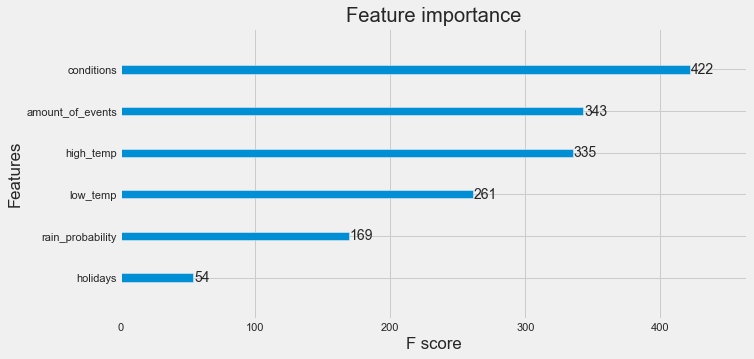

In [99]:
x1=xgb.plot_importance(bst)
x1.figure.set_size_inches(10, 5) 

Получается, что наибольшее влияние имеют погодные условия. Скорее всего, просто летом, во время отпусков погода лучше, и влияет на самом деле сезонность.